In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.circuit.library import HamiltonianGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Pauli, partial_trace
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt

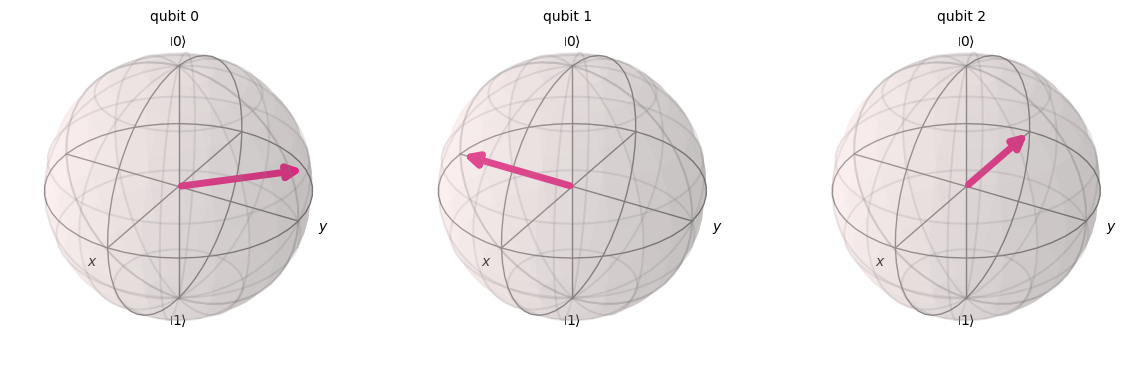

In [44]:
from math import pi

def process_qbit(qc: QuantumCircuit, qbit: int):
    
    qc.h(qbit)

    for i in range(qbit - 1, -1, -1):
        qc.cp(np.pi / (2 ** (qbit - i)), qbit, i)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):

    for i in range(circuit.num_qubits - 1, -1, -1):
        process_qbit(circuit, i)
    swap_registers(circuit, n)
    return circuit

# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(1)
qc.draw()

sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

qft(qc,3)
qc.draw('mpl')

qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

QFT

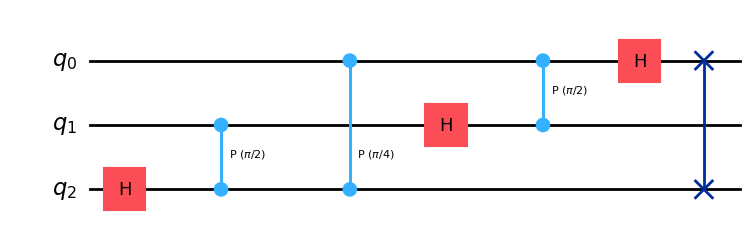

In [45]:
def process_qbit(qc: QuantumCircuit, qbit: int):
    
    qc.h(qbit)

    for i in range(qbit - 1, -1, -1):
        qc.cp(np.pi / (2 ** (qbit - i)), qbit, i)
    
    return qc


def qft_one(qc: QuantumCircuit):

    for i in range(qc.num_qubits - 1, -1, -1):
        process_qbit(qc, i)

    for i in range(qc.num_qubits // 2):
        qc.swap(i, qc.num_qubits - i - 1)
    
    return qc

example_qft = QuantumCircuit(3)
qft_one(example_qft)
example_qft.draw('mpl')

IQFT

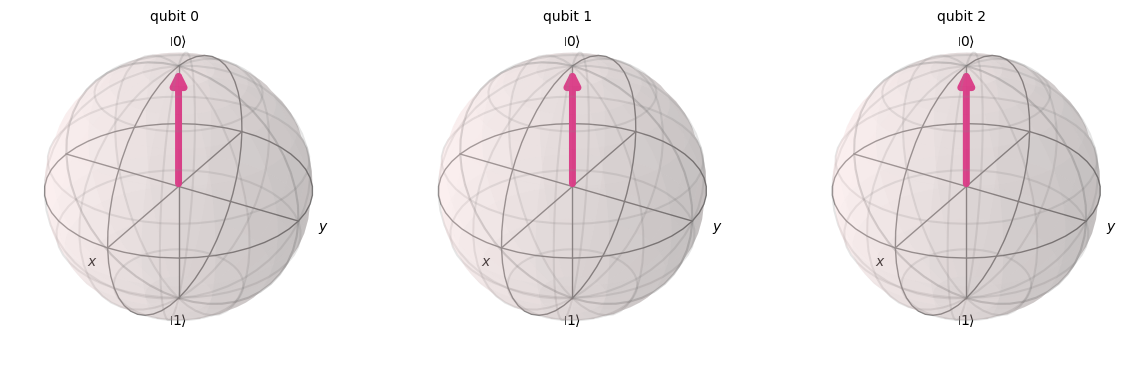

In [46]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(1)
qc.draw()

sim = Aer.get_backend("aer_simulator")

qft(qc,3)
qc.draw('mpl')

inv = qc.inverse()
qc.compose(inv, inplace=True)
qc.draw('mpl')

qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)


State preparation

In [47]:
def prepare(qc: QuantumCircuit, b: np.array):
    b_normalized = b / np.linalg.norm(b)
    qc.initialize(b_normalized, qc.qubits)

In [48]:
def plot_qubit_states(statevector, title):
    num_qubits = statevector.num_qubits
    fig = plt.figure(figsize=(num_qubits * 3, 3))
    for qubit in range(num_qubits):
        rho = partial_trace(statevector, [q for q in range(num_qubits) if q != qubit])
        x = rho.expectation_value(Pauli("X")).real
        y = rho.expectation_value(Pauli("Y")).real
        z = rho.expectation_value(Pauli("Z")).real
        ax = fig.add_subplot(1, num_qubits, qubit + 1, projection="3d")
        plot_bloch_vector([x, y, z], title=f"Qubit {qubit}", ax=ax)
    plt.suptitle(title)
    plt.show()

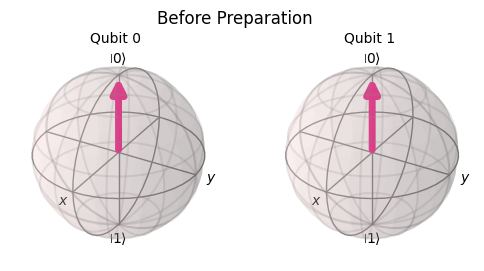

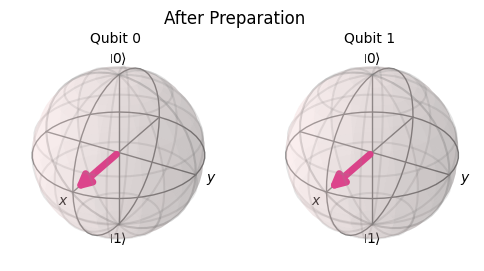

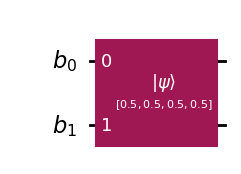

In [ ]:
b_reg = QuantumRegister(2, "b")
qc = QuantumCircuit(b_reg)

initial_state = Statevector.from_label("00")

b = np.array([0.5, 0.5, 0.5, 0.5])
prepare(qc, b)

final_state = Statevector(qc)


plot_qubit_states(initial_state, "Before Preparation")
plot_qubit_states(final_state, "After Preparation")

plt.show()

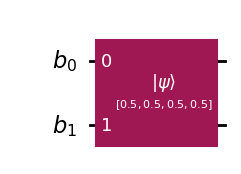

In [58]:
qc.draw("mpl", style="iqx")

Hadamart Gate

In [61]:
def hadamart(qc: QuantumCircuit, qbit: int):
    qc.h(qbit)

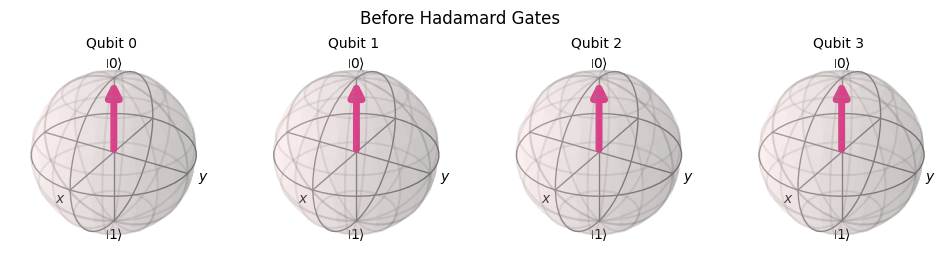

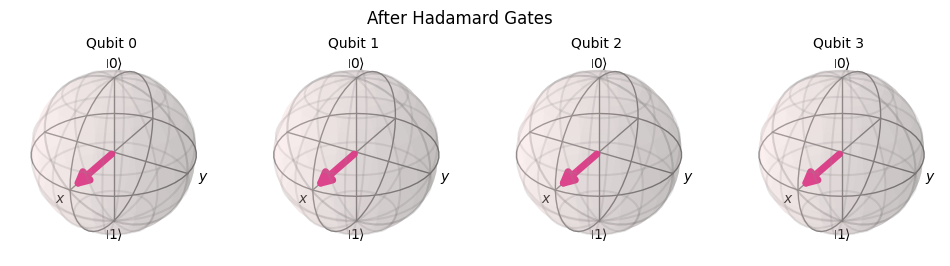

In [63]:
n_qubits = 3
c_reg = QuantumRegister(n_qubits, "c")
b_reg = QuantumRegister(1, "b")
qc = QuantumCircuit(c_reg, b_reg)

initial_state = Statevector.from_label("0" * qc.num_qubits)

for i in range(4):
    hadamart(qc, i)

final_state = Statevector(qc)

plot_qubit_states(initial_state, "Before Hadamard Gates")
plot_qubit_states(final_state, "After Hadamard Gates")

plt.show()

c:\Users\olegs\AppData\Local\Programs\Python\Python311\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: c:\Users\olegs\AppData\Local\Programs\Python\Python311\Lib\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


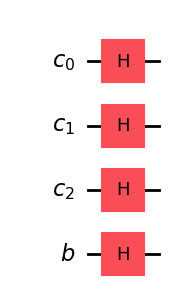

In [64]:
qc.draw("mpl", style="iqx")

Controlled Hamiltonian-gate

In [66]:
def eiAt(circuit, c_reg, b_reg, A, t):

    num_controls = len(c_reg)

    for k in range(num_controls):

        scaled_time = (2**k) * t

        h_gate = HamiltonianGate(-A, scaled_time)
        controlled_h = h_gate.control(1)

        circuit.append(controlled_h, [c_reg[k]] + list(b_reg))


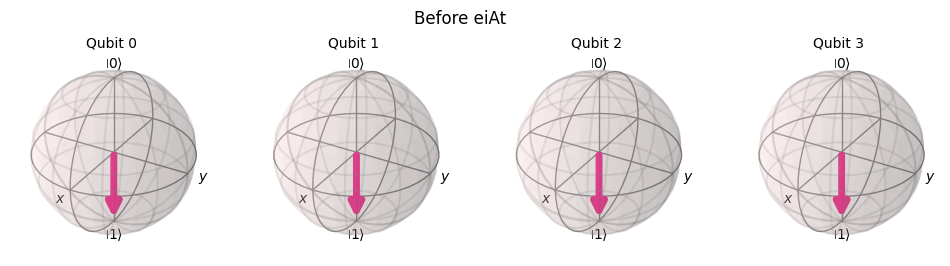

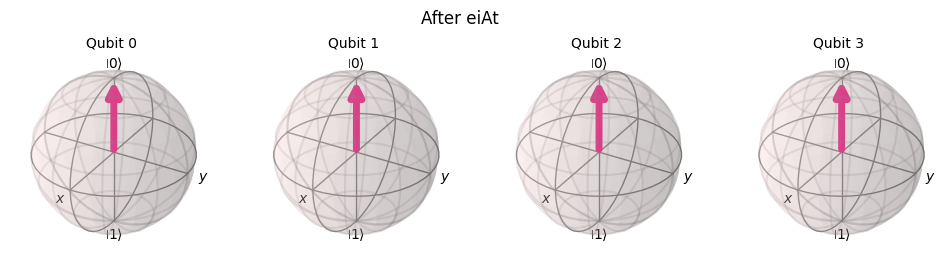

c:\Users\olegs\AppData\Local\Programs\Python\Python311\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: c:\Users\olegs\AppData\Local\Programs\Python\Python311\Lib\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


In [71]:
n_qubits = 3
t = 0.1

c_reg = QuantumRegister(n_qubits, "c")
b_reg = QuantumRegister(1, "b")
qc = QuantumCircuit(c_reg, b_reg)

A = SparsePauliOp("Z")

initial_state = Statevector.from_label("1" * qc.num_qubits)

eiAt(qc, c_reg, b_reg, A, t)

final_state = Statevector(qc)

plot_qubit_states(initial_state, "Before eiAt")
plot_qubit_states(final_state, "After eiAt")

qc.draw("mpl", style="iqx")
plt.show()

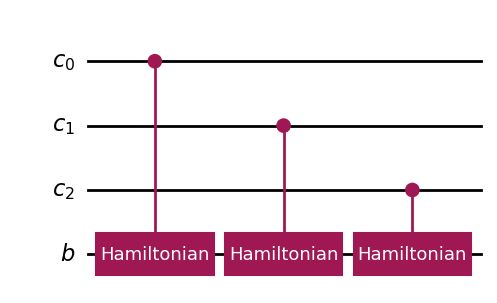

In [69]:
qc.draw("mpl", style="iqx")

Reversed controlled Hamiltonian-gate

In [74]:
def reverse_eiAt(circuit, c_reg, b_reg, A, t):
    num_controls = len(c_reg)

    for k in reversed(range(num_controls)):
        scaled_time = (2**k) * t

        h_gate = HamiltonianGate(A, scaled_time) 
        controlled_h = h_gate.control(1)

        circuit.append(controlled_h, [c_reg[k]] + list(b_reg))

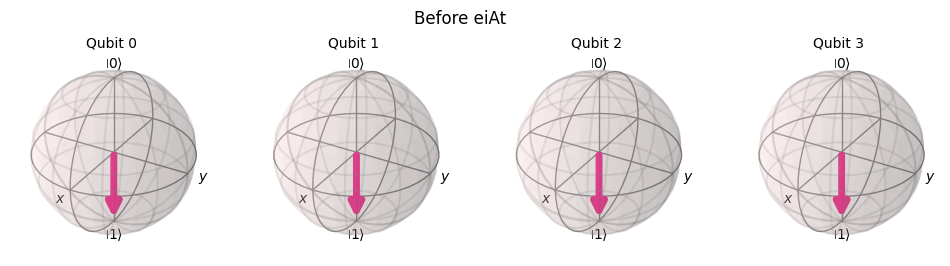

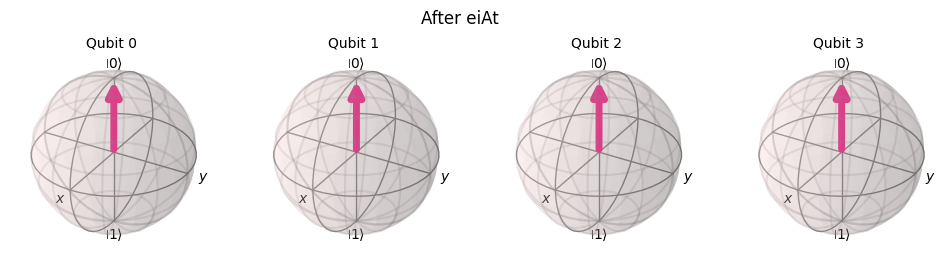

c:\Users\olegs\AppData\Local\Programs\Python\Python311\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: c:\Users\olegs\AppData\Local\Programs\Python\Python311\Lib\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


In [77]:
n_qubits = 3
t = 0.1

c_reg = QuantumRegister(n_qubits, "c")
b_reg = QuantumRegister(1, "b")
qc = QuantumCircuit(c_reg, b_reg)

A = SparsePauliOp("Z")

initial_state = Statevector.from_label("1" * qc.num_qubits)

reverse_eiAt(qc, c_reg, b_reg, A, t)

final_state = Statevector(qc)

plot_qubit_states(initial_state, "Before eiAt")
plot_qubit_states(final_state, "After eiAt")

qc.draw("mpl", style="iqx")
plt.show()

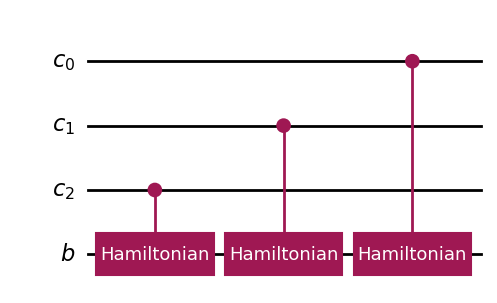

In [78]:
qc.draw("mpl", style="iqx")